In [1]:
import lib.tf_silent
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B
import tensorflow as tf

In [2]:
# number of training samples
num_train_samples = 10000
# number of test samples
num_test_samples = 1000
# kinematic viscosity
nu = 0.01 / np.pi

In [3]:
# build a core network model
network1 = Network() # pass a = 10 to see solution divergence
network = network1.build()
network.summary()
# build a PINN model
pinn = PINN(network, nu).build()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 activation_2 (Activation)   (None, 20)                0     

In [4]:
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)          # t_eqn =  0 ~ +1
tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1                # x_eqn = -1 ~ +1
tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
tx_ini[..., 0] = 0                                     # t_ini =  0
tx_bnd = np.random.rand(num_train_samples, 2)          # t_bnd =  0 ~ +1
tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1      # x_bnd = -1 or +1
# create training output
u_eqn = np.zeros((num_train_samples, 1))               # u_eqn = 0
u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

In [5]:
# train the model using L-BFGS-B algorithm
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [ u_eqn,  u_ini,  u_bnd]

In [6]:
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train) # add a
lbfgs.fit()
# print(lbfgs.model.get_weights().shape)
# compute splitting indices)

Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 739s 148ms/step


In [7]:
network1.A.numpy() # to see if it is changed

0.34

In [8]:
num_test_samples = 1000
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
print(tx.shape)

(1000000, 2)


In [9]:
u = network.predict(tx, batch_size=num_test_samples)

print(u.shape)
u = u.reshape(t.shape)
print(u.shape)

1000/1000 [==============================] - 6s 5ms/step
(1000000, 1)
(1000, 1000)


1/1 [==============================] - 0s 73ms/step


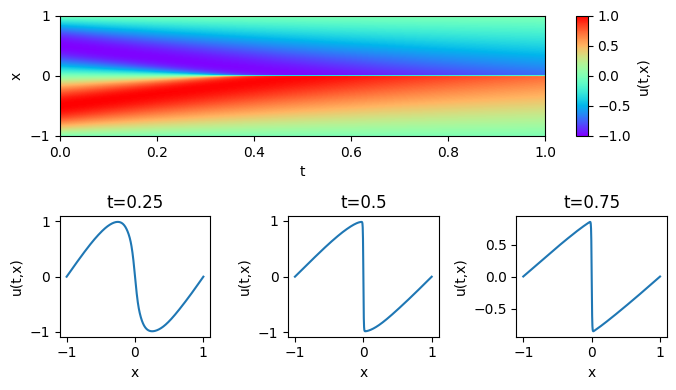

In [10]:
# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.25, 0.5, 0.75]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()

In [11]:
lbfgs.loss

1.588893064763397e-05

# Mode Analysis

In [22]:
num_test_samples = 400
N = num_test_samples
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
tx_test = np.stack([np.full(t_flat.shape, 0.75), x_flat], axis=-1)
u_test = network.predict(tx_test)

13/13 [==============================] - 0s 6ms/step


Text(0, 0.5, '$F_k$')

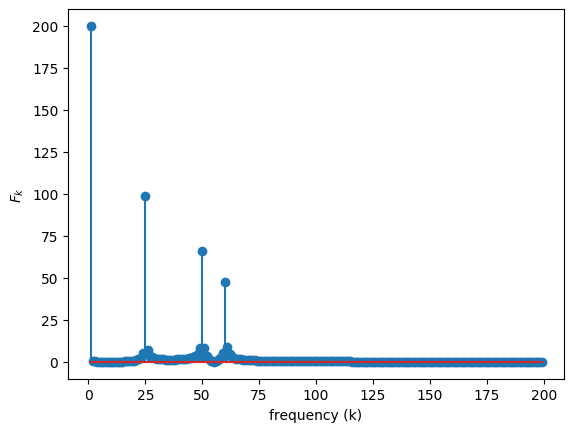

In [23]:

Sin = np.sin(np.pi*x_flat) + 1/2*np.sin(np.pi*25*x_flat) + 1/3*np.sin(np.pi*50*x_flat) + 1/4*np.sin(np.pi*60*x_flat) 
kappa2= 2*np.pi/(2*np.pi)*np.arange(-N/2,N/2) # define frequencies, from -N/2 to N/2, from negative to positive
kappa3=np.fft.fftshift(kappa2)
Sin_fft = np.fft.fft(Sin)
plt.stem( kappa3[1:N//2] , np.abs(Sin_fft)[1:N//2]) # index for positive coefficients
# plt.xlim([0,10])
plt.xlabel('frequency (k)')
plt.ylabel('$F_k$')

Text(0, 0.5, '$F_k$')

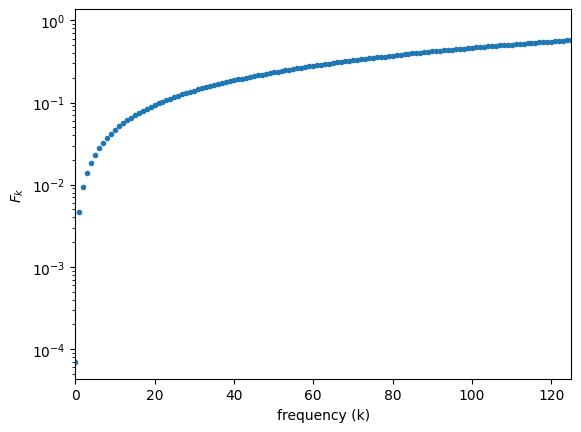

In [24]:

u_fft = np.fft.fft(u_test)
plt.semilogy(kappa3 ,np.abs(u_fft),'.')
plt.xlim([0,125])
plt.xlabel('frequency (k)')
plt.ylabel('$F_k$')

<StemContainer object of 3 artists>

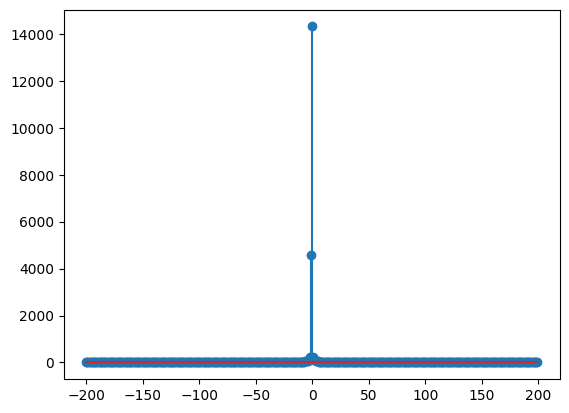

In [25]:
plt.stem(kappa3, np.abs(1/u_fft),'.')